Importai

In [1]:
import pandas as pd
import umap.umap_ as umap
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, classification_report
import graphviz 
from sklearn.model_selection import GridSearchCV

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Read file and prepare data

In [2]:
# Read the CSV file into a DataFrame
csv_file_path = 'Wholesale customers data.csv'
df = pd.read_csv(csv_file_path)

# Drop the 'Region' column
df = df.drop('Region', axis=1)

# Replace values in the 'Channel' column
#df['Channel'] = df['Channel'].replace({1: 'Horeca', 2: 'Retail'})

# Convert 'Channel' to categorical data type
#df['Channel'] = pd.Categorical(df['Channel'])

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

features1 = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
# create features and labels dataframes
num_features = df[features1]
labels = df['Channel'] #cia algoritmui veliau 
# Normalised data 
scaler = StandardScaler()
df_scaled = scaler.fit_transform(num_features)
df_scaled = pd.DataFrame(df_scaled, columns=features1)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# reduce dimensions with UMAP for further calssifying
reducer = umap.UMAP(n_neighbors=15, n_jobs = 1, n_components=2, min_dist=0.1, spread=1.0, random_state=42)
df_umap = reducer.fit_transform(df_scaled)
df_umap = pd.DataFrame(df_umap, columns=['UMAP1', 'UMAP2'])

df_scaled.insert(0, 'Channel', df['Channel'])
df_umap.insert(0, 'Channel', df['Channel'])

Data splitting

In [3]:
def split_df(df, random_state = 42):
    # Separate data into class 1 and class 2
    class_1_data = df[df['Channel'] == 1]
    class_2_data = df[df['Channel'] == 2]

    # Randomly select 22 instances from each class
    class_1_sample = class_1_data.sample(n=22, random_state = random_state)
    class_2_sample = class_2_data.sample(n=22, random_state = random_state)

    # Combine the samples to create the balanced test set
    df_test_balanced = pd.concat([class_1_sample, class_2_sample])

    # Remove the samples used for the test set from the original dataframe
    df_remaining = df.drop(df_test_balanced.index)

    print("Size of test and validate df:", df_remaining.shape)

    # Split the remaining data into train and validation sets. 44/396 sets the proportions for splitting. We want to have 10% of original data in validate set.
    df_train, df_valid = train_test_split(df_remaining, test_size = 44/396, random_state = random_state) #set random_state for consistent results

    # Verify the distribution of labels in the balanced test set
    test_label_distribution_balanced = df_test_balanced['Channel'].value_counts()
    print("Balanced Test Set Label Distribution:")
    print(test_label_distribution_balanced)

    # Verify the distribution of labels in the validation set
    valid_label_distribution = df_valid['Channel'].value_counts()
    print("\nValidation Set Label Distribution:")
    print(valid_label_distribution)
    return df_train, df_valid, df_test_balanced

df_train, df_validate, df_test = split_df(df_scaled, random_state = 42)
umap_train, umap_validate, umap_test = split_df(df_umap, random_state = 42)

Size of test and validate df: (396, 7)
Balanced Test Set Label Distribution:
Channel
1    22
2    22
Name: count, dtype: int64

Validation Set Label Distribution:
Channel
1    33
2    11
Name: count, dtype: int64
Size of test and validate df: (396, 3)
Balanced Test Set Label Distribution:
Channel
1    22
2    22
Name: count, dtype: int64

Validation Set Label Distribution:
Channel
1    33
2    11
Name: count, dtype: int64


Finding the best parameters:

In [ ]:
# DF decision tree
dt_classifier_df = DecisionTreeClassifier(random_state=42)

# Define the parameter grid to search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 4, 7],
    'min_samples_split': [2, 4, 3],
    'min_samples_leaf': [6, 2, 3]
}
#Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}  0.9090909090909091
# Best Parameters: {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}
# Accuracy on df's Validation Set: 0.9090909090909091
#Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
#Best Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
# Create the GridSearchCV object
grid_search = GridSearchCV(dt_classifier_df, param_grid, cv=5, scoring='f1')

# Fit the model to the training data
grid_search.fit(df_train[features1], df_train['Channel'])

# Print accuracy for each combination of parameters
results = grid_search.cv_results_
for mean_score, params in zip(results['mean_test_score'], results['params']):
    print(f"Accuracy: {mean_score:.4f} | Parameters: {params}")

# Get the best parameters and the corresponding model
best_params = grid_search.best_params_
best_dt_classifier = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters:", best_params)

# Predict the labels for the validation set using the best model
y_pred_df = best_dt_classifier.predict(df_validate[features1])

# Evaluate the model on df's validation set
accuracy_df = accuracy_score(df_validate['Channel'], y_pred_df)
print("Accuracy on df's Validation Set:", accuracy_df)

# Display classification report for df
print("Classification Report for df:")
print(classification_report(df_validate['Channel'], y_pred_df))

Decision tree realisation

In [20]:
best_params = {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}

# Create a new instance of DecisionTreeClassifier with the best parameters
dt_classifier_df = DecisionTreeClassifier(**best_params, random_state=42)

# Fit the model to the training data
dt_classifier_df.fit(df_train[features1], df_train['Channel'])

# Predict the labels for the validation set using the best model
y_pred_df = dt_classifier_df.predict(df_validate[features1])

# Evaluate the model on df's validation set
accuracy_df = accuracy_score(df_validate['Channel'], y_pred_df)
print("Accuracy on df's Validation Set:", accuracy_df)

# Display classification report for df
print("Classification Report for df:")
print(classification_report(df_validate['Channel'], y_pred_df))

# dt_classifier_umap = DecisionTreeClassifier(random_state=42)
# dt_classifier_umap.fit(umap_train[['UMAP1', 'UMAP2']], umap_train['Channel'])

# # Predict the labels for the validation set
# y_pred_umap = dt_classifier_umap.predict(umap_validate[['UMAP1', 'UMAP2']])

# # Evaluate the model on df_umap's validation set
# accuracy_umap = accuracy_score(umap_validate['Channel'], y_pred_umap)
# print("\nAccuracy on df_umap's Validation Set:", accuracy_umap)

# # Display classification report for df_umap
# print("Classification Report for df_umap:")
# print(classification_report(umap_validate['Channel'], y_pred_umap))


Accuracy on df's Validation Set: 0.9090909090909091
Classification Report for df:
              precision    recall  f1-score   support

           1       0.91      0.97      0.94        33
           2       0.89      0.73      0.80        11

    accuracy                           0.91        44
   macro avg       0.90      0.85      0.87        44
weighted avg       0.91      0.91      0.91        44



Decision tree visualisations:


DF tree:

UMAP tree:


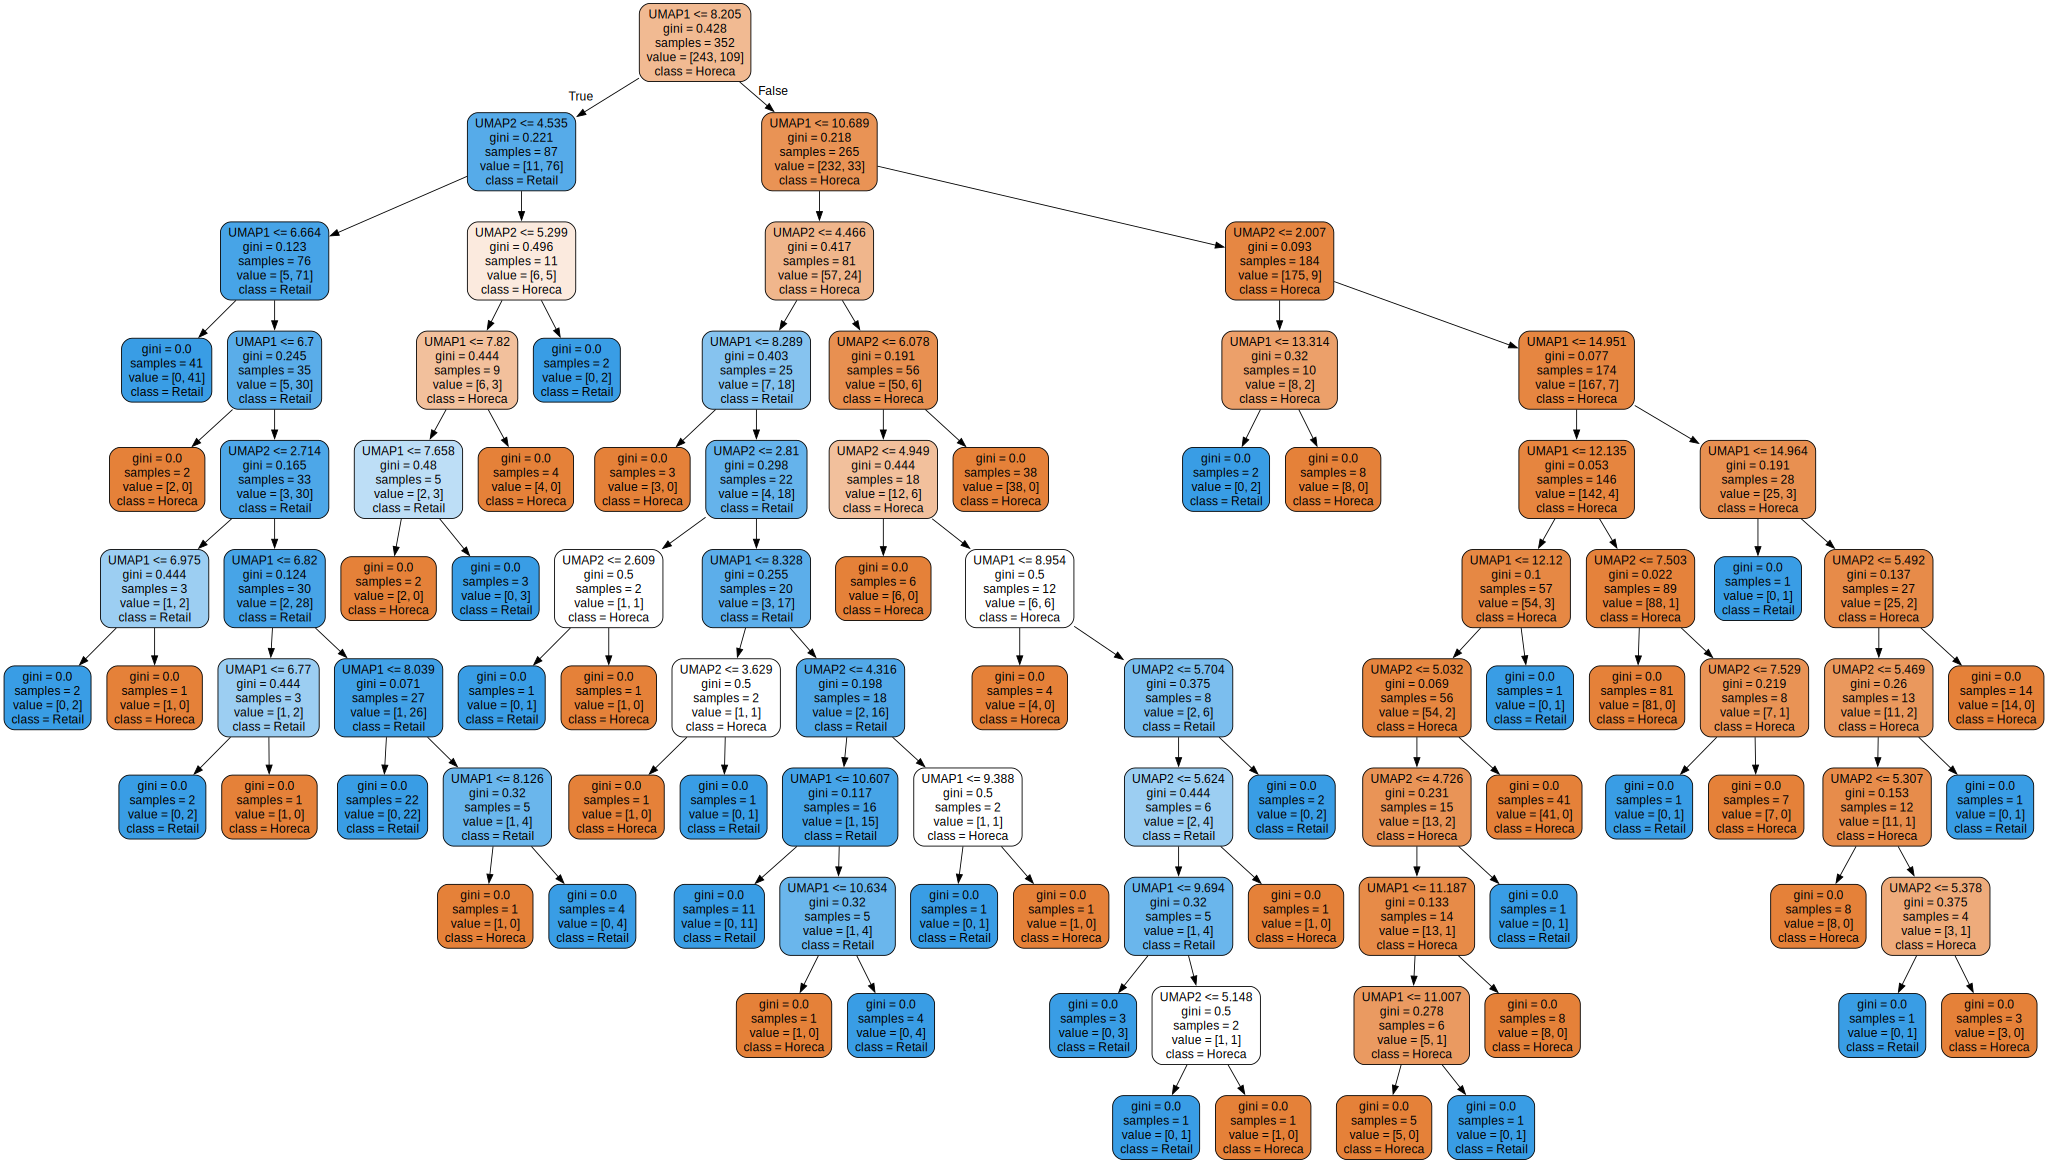

In [19]:
print('\nDF tree:')
dot_data = export_graphviz(
    dt_classifier_df, 
    out_file=None,
    feature_names = features1,
    class_names = ["Horeca", "Retail"],
    filled = True,
    rounded = True
    )

graph = graphviz.Source(dot_data, format = "png") 
graph.render("DF Decision tree", view = True, cleanup = True) 
graph

print('\nUMAP tree:')
dot_data = export_graphviz(
    dt_classifier_umap, 
    out_file=None,
    feature_names = ["UMAP1", "UMAP2"],
    class_names = ["Horeca", "Retail"],
    filled = True,
    rounded = True
    )

graph = graphviz.Source(dot_data, format = "png") 
graph.render("UMAP Decision tree", view = True, cleanup = True) 
graph